In [1]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt

In [2]:
xr_ref = xr.open_dataset('Output_SolarWind\\xr_final_SI_combined_SolarWind.nc')

In [3]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

In [4]:
SPP_maxcap_wind = 90
SPP_mincap_wind = 16
VSPP_maxcap_wind = 10
VSPP_mincap_wind = 1

SPP_maxcap_solar = 90
SPP_mincap_solar = 15
VSPP_maxcap_solar = 10
VSPP_mincap_solar = 1

In [5]:
######## PDP ############################################################
SPP_quota_wind_total =  5335
SPP_quota_wind_R0 = 0
SPP_quota_wind_R1 = 0
SPP_quota_wind_R2 = 5115
SPP_quota_wind_R3 =  220
SPP_quota_wind_R4 =  0

VSPP_quota_wind_total =  0
VSPP_quota_wind_R0 =  0
VSPP_quota_wind_R1 =  0
VSPP_quota_wind_R2 =  0
VSPP_quota_wind_R3 =  0
VSPP_quota_wind_R4 = 0

SPP_quota_solar_total =  18810
SPP_quota_solar_R0 =  0
SPP_quota_solar_R1 =  3150
SPP_quota_solar_R2 =  3060
SPP_quota_solar_R3 = 8100
SPP_quota_solar_R4 =  4500

VSPP_quota_solar_total = 0
VSPP_quota_solar_R0 = 0
VSPP_quota_solar_R1 =  0
VSPP_quota_solar_R2 =  0
VSPP_quota_solar_R3 =   0
VSPP_quota_solar_R4 =  0
######## PDP ############################################################

In [6]:
######################## model #####################################################
m = linopy.Model()

SPP_built_wind = m.add_variables(integer=True,upper=300,lower=0, coords=xr_ref.coords, name='built_SPP_wind')
VSPP_built_wind = m.add_variables(integer=True,upper=300,lower=0, coords=xr_ref.coords, name='built_VSPP_wind')
SPP_built_solar = m.add_variables(integer=True,upper=300,lower=0, coords=xr_ref.coords, name='built_SPP_solar')
VSPP_built_solar = m.add_variables(integer=True,upper=300,lower=0, coords=xr_ref.coords, name='built_VSPP_solar')

SPP_area_wind = m.add_variables(integer=False,lower=0.0, coords=xr_ref.coords, name='area_SPP_wind')
VSPP_area_wind = m.add_variables(integer=False,lower=0.0, coords=xr_ref.coords, name='area_VSPP_wind')
SPP_area_solar = m.add_variables(integer=False,lower=0.0, coords=xr_ref.coords, name='area_SPP_solar')
VSPP_area_solar = m.add_variables(integer=False,lower=0.0, coords=xr_ref.coords, name='area_VSPP_solar')

In [7]:
constr_built_logic = m.add_constraints((SPP_built_wind + VSPP_built_wind + SPP_built_solar + VSPP_built_solar) <=  600, name='constr_built_logic')

constr_area_wind = m.add_constraints((SPP_area_wind + VSPP_area_wind) <= (xr_ref['area_wind']), name='constr_area_wind')
constr_SPP_area_wind = m.add_constraints(SPP_area_wind <= (xr_ref['area_wind']), name='constr_SPP_area_wind')
constr_VSPP_area_wind = m.add_constraints(VSPP_area_wind <= (xr_ref['area_wind']), name='constr_VSPP_area_wind')

constr_area_solar = m.add_constraints((SPP_area_solar + VSPP_area_solar) <= (xr_ref['area_solar']), name='constr_area_solar')
constr_SPP_area_solar = m.add_constraints(SPP_area_solar  <= (xr_ref['area_solar']), name='constr_SPP_area_solar')
constr_VSPP_area_solar = m.add_constraints(VSPP_area_solar  <= (xr_ref['area_solar']), name='constr_VSPP_area_solar')

constr_area = m.add_constraints((SPP_area_wind + VSPP_area_wind + SPP_area_solar + VSPP_area_solar) <= (xr_ref['area']), name='constr_area')

constr_SPP_capacity_wind_max = m.add_constraints((SPP_area_wind*mwperkm2_wind) <= (SPP_maxcap_wind*SPP_built_wind), name='constr_SPP_capacity_wind_max')
constr_SPP_capacity_wind_min = m.add_constraints((SPP_area_wind*mwperkm2_wind) >= (SPP_mincap_wind*SPP_built_wind), name='constr_SPP_capacity_wind_min')
constr_VSPP_capacity_wind_max = m.add_constraints((VSPP_area_wind*mwperkm2_wind) <= (VSPP_maxcap_wind*VSPP_built_wind), name='constr_VSPP_capacity_wind_max')
constr_VSPP_capacity_wind_min = m.add_constraints((VSPP_area_wind*mwperkm2_wind) >= (VSPP_mincap_wind*VSPP_built_wind), name='constr_VSPP_capacity_wind_min')

constr_SPP_capacity_solar_max = m.add_constraints((SPP_area_solar*mwperkm2_solar) <= (SPP_maxcap_solar*SPP_built_solar), name='constr_SPP_capacity_solar_max')
constr_SPP_capacity_solar_min = m.add_constraints((SPP_area_solar*mwperkm2_solar) >= (SPP_mincap_solar*SPP_built_solar), name='constr_SPP_capacity_solar_min')
constr_VSPP_capacity_solar_max = m.add_constraints((VSPP_area_solar*mwperkm2_solar) <= (VSPP_maxcap_solar*VSPP_built_solar), name='constr_VSPP_capacity_solar_max')
constr_VSPP_capacity_solar_min = m.add_constraints((VSPP_area_solar*mwperkm2_solar) >= (VSPP_mincap_solar*VSPP_built_solar), name='constr_VSPP_capacity_solar_min')


In [8]:
############################################################################################################################################################

constr_SPP_quota_wind = m.add_constraints((SPP_area_wind.sum()) * mwperkm2_wind >= SPP_quota_wind_total , name='constr_SPP_quota_wind')

constr_SPP_quota_wind_r0 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R0',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R0, name='constr_SPP_quota_wind_r0')

constr_SPP_quota_wind_r1 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R1',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R1, name='constr_SPP_quota_wind_r1')

constr_SPP_quota_wind_r2 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R2',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R2, name='constr_SPP_quota_wind_r2')

constr_SPP_quota_wind_r3 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R3',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R3, name='constr_SPP_quota_wind_r3')

constr_SPP_quota_wind_r4 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R4',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R4, name='constr_SPP_quota_wind_r4')

############################################################################################################################################################

constr_VSPP_quota_wind = m.add_constraints((VSPP_area_wind.sum()) * mwperkm2_wind >= VSPP_quota_wind_total , name='constr_VSPP_quota_wind')

constr_VSPP_quota_wind_r0 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R0',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R0, name='constr_VSPP_quota_wind_r0')

constr_VSPP_quota_wind_r1 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R1',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R1, name='constr_VSPP_quota_wind_r1')

constr_VSPP_quota_wind_r2 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R2',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R2, name='constr_VSPP_quota_wind_r2')

constr_VSPP_quota_wind_r3 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R3',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R3, name='constr_VSPP_quota_wind_r3')

constr_VSPP_quota_wind_r4 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R4',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R4, name='constr_VSPP_quota_wind_r4')
############################################################################################################################################################

constr_SPP_quota_solar = m.add_constraints((SPP_area_solar.sum()) * mwperkm2_solar >= SPP_quota_solar_total, name='constr_SPP_quota_solar')

constr_SPP_quota_solar_r0 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R0',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R0, name='constr_SPP_quota_solar_r0')

constr_SPP_quota_solar_r1 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R1',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R1, name='constr_SPP_quota_solar_r1')

constr_SPP_quota_solar_r2 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R2',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R2, name='constr_SPP_quota_solar_r2')

constr_SPP_quota_solar_r3 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R3',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R3, name='constr_SPP_quota_solar_r3')

constr_SPP_quota_solar_r4 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R4',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R4, name='constr_SPP_quota_solar_r4')

############################################################################################################################################################

constr_VSPP_quota_solar = m.add_constraints((VSPP_area_solar.sum()) * mwperkm2_solar >= VSPP_quota_solar_total, name='constr_VSPP_quota_solar')

constr_VSPP_quota_solar_r0 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R0',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R0, name='constr_VSPP_quota_solar_r0')

constr_VSPP_quota_solar_r1 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R1',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R1, name='constr_VSPP_quota_solar_r1')

constr_VSPP_quota_solar_r2 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R2',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R2, name='constr_VSPP_quota_solar_r2')

constr_VSPP_quota_solar_r3 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R3',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R3, name='constr_VSPP_quota_solar_r3')

constr_VSPP_quota_solar_r4 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R4',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R4, name='constr_VSPP_quota_solar_r4')

############################################################################################################################################################


In [9]:
# obj = (-1000) * (
#     (((SPP_built_wind) + (SPP_area_wind/xr_ref['area_wind'])) * xr_ref['SI_Wind']).where(xr_ref['area_wind'] > 0,drop=True).sum()
#     + (((VSPP_built_wind) + (VSPP_area_wind/xr_ref['area_wind'])) * xr_ref['SI_Wind']).where(xr_ref['area_wind'] > 0,drop=True).sum()
#     + (((SPP_built_solar) + (SPP_area_solar/xr_ref['area_solar'])) * xr_ref['SI_Solar']).where(xr_ref['area_solar'] > 0,drop=True).sum()
#     + (((VSPP_built_solar) + (VSPP_area_solar/xr_ref['area_solar'])) * xr_ref['SI_Solar']).where(xr_ref['area_solar'] > 0,drop=True).sum()
# )

obj = (-1000) * (
    (((SPP_area_wind/xr_ref['area_wind'])) * xr_ref['SI_Wind']).where(xr_ref['area_wind'] > 0,drop=True).sum()
    + (((VSPP_area_wind/xr_ref['area_wind'])) * xr_ref['SI_Wind']).where(xr_ref['area_wind'] > 0,drop=True).sum()
    + (((SPP_area_solar/xr_ref['area_solar'])) * xr_ref['SI_Solar']).where(xr_ref['area_solar'] > 0,drop=True).sum()
    + (((VSPP_area_solar/xr_ref['area_solar'])) * xr_ref['SI_Solar']).where(xr_ref['area_solar'] > 0,drop=True).sum()
)

m.add_objective(obj)

In [10]:
print("presolve = ",m)

presolve =  Linopy MILP model

Variables:
----------
 * built_SPP_wind (pol_id)
 * built_VSPP_wind (pol_id)
 * built_SPP_solar (pol_id)
 * built_VSPP_solar (pol_id)
 * area_SPP_wind (pol_id)
 * area_VSPP_wind (pol_id)
 * area_SPP_solar (pol_id)
 * area_VSPP_solar (pol_id)

Constraints:
------------
 * constr_built_logic (pol_id)
 * constr_area_wind (pol_id)
 * constr_SPP_area_wind (pol_id)
 * constr_VSPP_area_wind (pol_id)
 * constr_area_solar (pol_id)
 * constr_SPP_area_solar (pol_id)
 * constr_VSPP_area_solar (pol_id)
 * constr_area (pol_id)
 * constr_SPP_capacity_wind_max (pol_id)
 * constr_SPP_capacity_wind_min (pol_id)
 * constr_VSPP_capacity_wind_max (pol_id)
 * constr_VSPP_capacity_wind_min (pol_id)
 * constr_SPP_capacity_solar_max (pol_id)
 * constr_SPP_capacity_solar_min (pol_id)
 * constr_VSPP_capacity_solar_max (pol_id)
 * constr_VSPP_capacity_solar_min (pol_id)
 * constr_SPP_quota_wind
 * constr_SPP_quota_wind_r0
 * constr_SPP_quota_wind_r1
 * constr_SPP_quota_wind_r2
 * co

In [11]:
m.solve(solver_name='highs',
        # mip_abs_gap = 0.0018,
        # mip_rel_gap = 0.0018,
        )

print('aftersolve = ',m)
solution = m.solution
solution = solution.fillna(0)
solution.to_netcdf(path='Output_SolarWind\\InvestmentMap_SolarWind.nc')
print(solution)

Writing integer variables.: 100%|██████████| 4/4 [00:00<00:00, 24.61it/s]


aftersolve =  Linopy MILP model

Variables:
----------
 * built_SPP_wind (pol_id)
 * built_VSPP_wind (pol_id)
 * built_SPP_solar (pol_id)
 * built_VSPP_solar (pol_id)
 * area_SPP_wind (pol_id)
 * area_VSPP_wind (pol_id)
 * area_SPP_solar (pol_id)
 * area_VSPP_solar (pol_id)

Constraints:
------------
 * constr_built_logic (pol_id)
 * constr_area_wind (pol_id)
 * constr_SPP_area_wind (pol_id)
 * constr_VSPP_area_wind (pol_id)
 * constr_area_solar (pol_id)
 * constr_SPP_area_solar (pol_id)
 * constr_VSPP_area_solar (pol_id)
 * constr_area (pol_id)
 * constr_SPP_capacity_wind_max (pol_id)
 * constr_SPP_capacity_wind_min (pol_id)
 * constr_VSPP_capacity_wind_max (pol_id)
 * constr_VSPP_capacity_wind_min (pol_id)
 * constr_SPP_capacity_solar_max (pol_id)
 * constr_SPP_capacity_solar_min (pol_id)
 * constr_VSPP_capacity_solar_max (pol_id)
 * constr_VSPP_capacity_solar_min (pol_id)
 * constr_SPP_quota_wind
 * constr_SPP_quota_wind_r0
 * constr_SPP_quota_wind_r1
 * constr_SPP_quota_wind_r2
 * 

In [12]:
xr_sol = xr.open_dataset('Output_SolarWind\\InvestmentMap_SolarWind.nc')
df_ref = pd.read_csv('Output_SolarWind\\df_final_SI_combined_SolarWind.csv')
df_ref = df_ref.drop_duplicates('pol_id')

mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available
print(df_ref)

       pol_id                                           geometry    area  \
0           0  POLYGON ((100.10833333333338 20.41666666666667...  4.9990   
1           1  POLYGON ((100.07500000000003 20.40277777777778...  2.3463   
2           2  POLYGON ((99.97222222222226 20.369444444444447...  9.1788   
3           3  POLYGON ((100.10833333333338 20.37500000000000...  2.5497   
4           4  POLYGON ((99.95833333333337 20.355555555555558...  2.9574   
...       ...                                                ...     ...   
15761   15761  POLYGON ((101.83611111111115 5.930555555555556...  0.0961   
15762   15762  POLYGON ((101.89722222222224 5.919444444444445...  0.0961   
15763   15763  POLYGON ((101.8388888888889 5.92777777777778, ...  2.1149   
15764   15764  POLYGON ((101.89166666666668 5.916666666666669...  0.5768   
15765   15765  POLYGON ((101.87500000000003 5.908333333333333...  1.5380   

       from_pol_id_wind list_pol_id_wind   SI_Wind  area_wind  \
0                     

In [13]:
df_sol= xr_sol.to_dataframe()
df_sol.reset_index(inplace=True)
print(df_sol)
xr_sol.close()
df = pd.merge(df_ref,df_sol,how='inner',on='pol_id')
print(df)

       pol_id  built_SPP_wind  built_VSPP_wind  built_SPP_solar  \
0           0             0.0              0.0              0.0   
1           1             0.0              0.0              1.0   
2           2             0.0              3.0              1.0   
3           3             0.0              0.0              1.0   
4           4             0.0              0.0              0.0   
...       ...             ...              ...              ...   
15761   15761             0.0              0.0              0.0   
15762   15762             0.0              0.0              0.0   
15763   15763             0.0              0.0              0.0   
15764   15764             0.0              0.0              0.0   
15765   15765             0.0              0.0              1.0   

       built_VSPP_solar  area_SPP_wind  area_VSPP_wind  area_SPP_solar  \
0                   6.0            0.0          0.0000          0.0000   
1                   0.0            0.0         

In [14]:
print(df.columns)

Index(['pol_id', 'geometry', 'area', 'from_pol_id_wind', 'list_pol_id_wind',
       'SI_Wind', 'area_wind', 'coord_wind', 'from_pol_id_solar',
       'list_pol_id_solar', 'SI_Solar', 'area_solar', 'coord_solar', 'ADM1_EN',
       'ADM1_TH', 'region', 'built_SPP_wind', 'built_VSPP_wind',
       'built_SPP_solar', 'built_VSPP_solar', 'area_SPP_wind',
       'area_VSPP_wind', 'area_SPP_solar', 'area_VSPP_solar'],
      dtype='object')


In [15]:
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, crs='epsg:4326')
df = df.set_geometry(df['geometry'])
df['capacity_wind'] = (df['area_SPP_wind'] + df['area_VSPP_wind']) * mwperkm2_wind
df['capacity_vspp_wind'] = (df['area_VSPP_wind']) * mwperkm2_wind
df['capacity_spp_wind'] = (df['area_SPP_wind']) * mwperkm2_wind

df['capacity_solar'] = (df['area_SPP_solar'] + df['area_VSPP_solar']) * mwperkm2_solar
df['capacity_vspp_solar'] = (df['area_VSPP_solar']) * mwperkm2_solar
df['capacity_spp_solar'] = (df['area_SPP_solar']) * mwperkm2_solar

df.to_csv('Output_SolarWind\\InvestmentMap_SolarWind.csv',index=False,encoding="utf-8-sig")

In [16]:
print("wind total = ",round(df['capacity_wind'].sum(),2))

print("SPP wind total = ",round(df['capacity_spp_wind'].sum(),2))
print("SPP wind R0 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R0')].sum(),2))
print("SPP wind R1 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R1')].sum(),2))
print("SPP wind R2 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R2')].sum(),2))
print("SPP wind R3 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R3')].sum(),2))
print("SPP wind R4 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R4')].sum(),2))

print("VSPP wind total = ",round(df['capacity_vspp_wind'].sum(),2))
print("VSPP wind R0 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R0')].sum(),2))
print("VSPP wind R1 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R1')].sum(),2))
print("VSPP wind R2 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R2')].sum(),2))
print("VSPP wind R3 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R3')].sum(),2))
print("VSPP wind R4 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R4')].sum(),2))

print("solar total = ",round(df['capacity_solar'].sum(),2))

print("SPP solar total = ",round(df['capacity_spp_solar'].sum(),2))
print("SPP solar R0 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R0')].sum(),2))
print("SPP solar R1 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R1')].sum(),2))
print("SPP solar R2 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R2')].sum(),2))
print("SPP solar R3 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R3')].sum(),2))
print("SPP solar R4 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R4')].sum(),2))

print("VSPP solar total = ",round(df['capacity_vspp_solar'].sum(),2))
print("VSPP solar R0 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R0')].sum(),2))
print("VSPP solar R1 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R1')].sum(),2))
print("VSPP solar R2 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R2')].sum(),2))
print("VSPP solar R3 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R3')].sum(),2))
print("VSPP solar R4 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R4')].sum(),2))



print("Max wind capacity = ",round(df['capacity_wind'].max(),2))
print("Min wind capacity = ",round(df['capacity_wind'].loc[df['capacity_wind']>0].min(),2))
print("Max solar capacity = ",round(df['capacity_solar'].max(),2))
print("Min solar capacity = ",round(df['capacity_solar'].loc[df['capacity_solar']>0].min(),2))

wind total =  109381.39
SPP wind total =  53637.79
SPP wind R0 =  146.79
SPP wind R1 =  8476.59
SPP wind R2 =  26506.73
SPP wind R3 =  5798.34
SPP wind R4 =  12709.34
VSPP wind total =  55743.6
VSPP wind R0 =  128.94
VSPP wind R1 =  10651.81
VSPP wind R2 =  23545.56
VSPP wind R3 =  8169.73
VSPP wind R4 =  13247.57
solar total =  900405.89
SPP solar total =  489388.0
SPP solar R0 =  829.29
SPP solar R1 =  86950.31
SPP solar R2 =  205505.08
SPP solar R3 =  72984.65
SPP solar R4 =  123118.67
VSPP solar total =  411017.9
VSPP solar R0 =  729.69
VSPP solar R1 =  83599.56
VSPP solar R2 =  197967.0
VSPP solar R3 =  39598.96
VSPP solar R4 =  89122.69
Max wind capacity =  3119.93
Min wind capacity =  1.0
Max solar capacity =  17591.44
Min solar capacity =  1.49


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


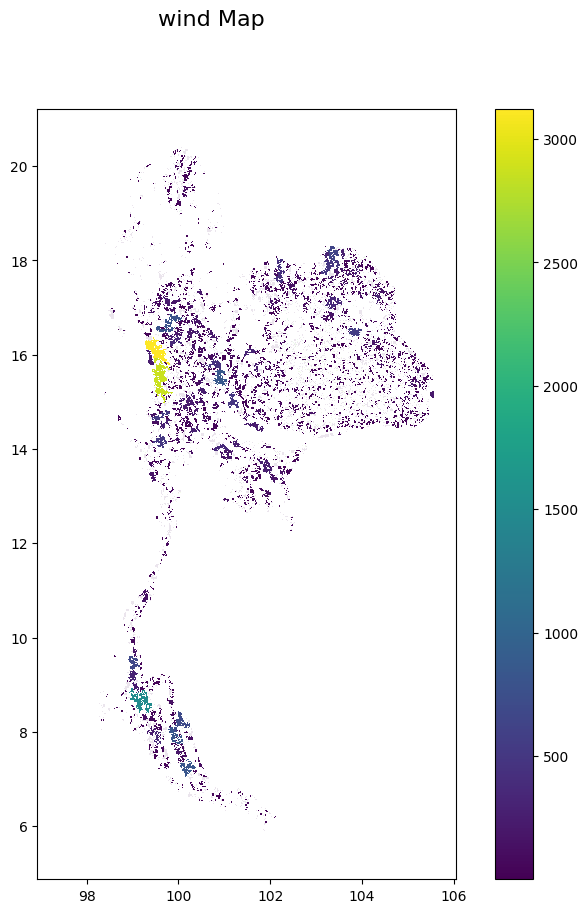

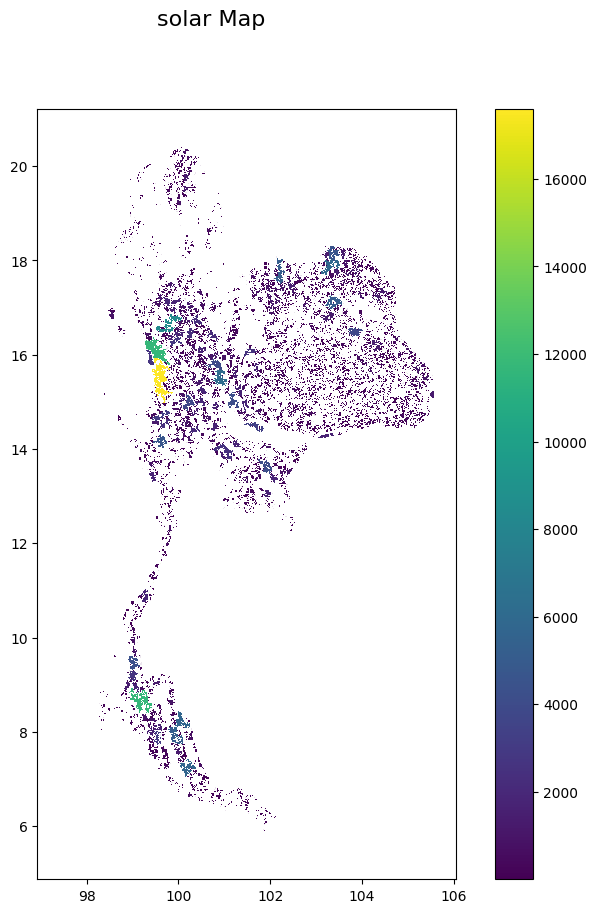

In [17]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
try:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('wind Map', fontsize=16)
    thailandmap.plot(ax = ax, color='none', edgecolor = 'white', zorder = 0)
    df.plot(ax = ax,column = 'SI_Wind', alpha = 0.1, zorder = 1)
    df.loc[df['capacity_wind']>0].plot(ax = ax,legend=True,zorder = 2,column = 'capacity_wind')
except:
    None
try:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('solar Map', fontsize=16)
    thailandmap.plot(ax = ax, color='none', edgecolor = 'white', zorder = 0)
    df.plot(ax = ax,column = 'SI_Solar', alpha = 0.1, zorder = 1)
    df.loc[df['capacity_solar']>0].plot(ax = ax,legend=True,zorder = 3,column = 'capacity_solar')
except:
    None

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


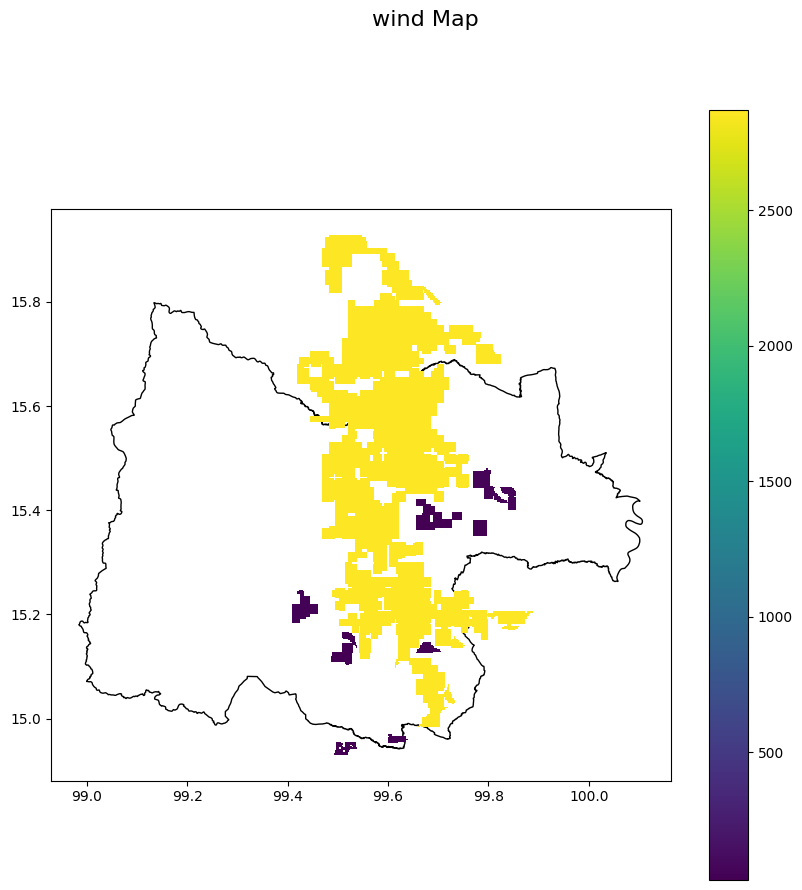

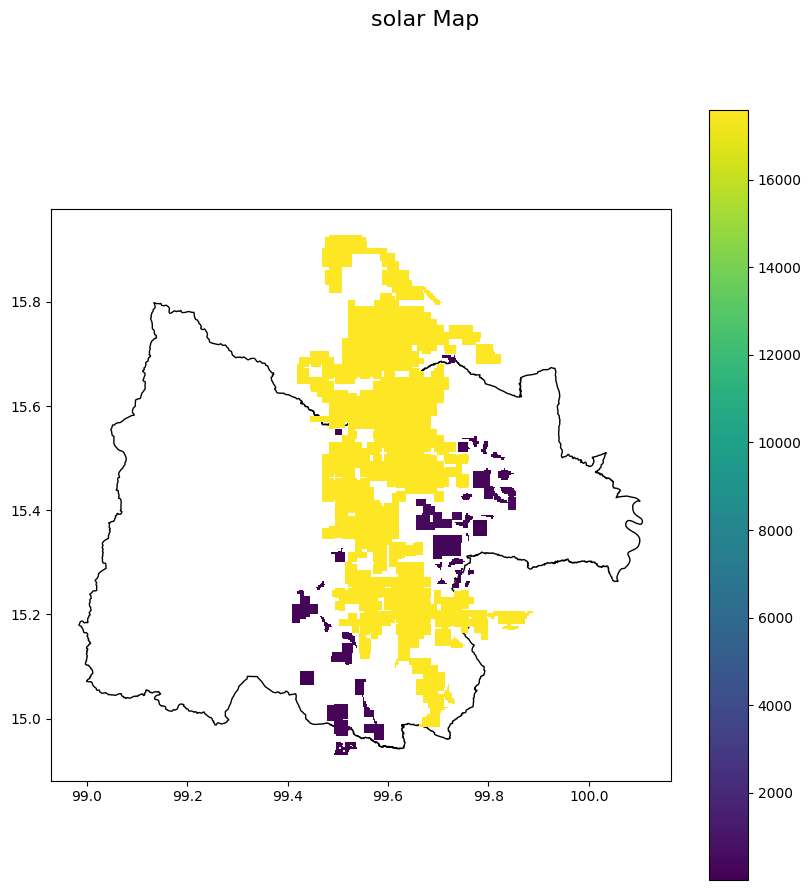

In [18]:
province = 'อุทัยธานี'
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
specificarea = thailandmap.loc[thailandmap['ADM1_TH'] == province]
bound = specificarea.unary_union.bounds


try:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('wind Map', fontsize=16)
    specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df.loc[(df['capacity_wind'] > 0) & (df['ADM1_TH'] == province)].plot(ax = ax,legend=True,zorder = 2,column = 'capacity_wind')
except:
    None
try:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('solar Map', fontsize=16)
    specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df.loc[(df['capacity_solar'] > 0) & (df['ADM1_TH'] == province)].plot(ax = ax,legend=True,zorder = 3,column = 'capacity_solar')
except:
    None